# Galaxies kNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = np.loadtxt("data/galaxies_train.csv", delimiter=",", skiprows=1)
test_data = np.loadtxt("data/galaxies_test.csv", delimiter=",", skiprows=1)

X_train = train_data[:,1:]
t_train = train_data[:,0]
X_test = test_data[:,1:]
t_test = test_data[:,0]
print("Number of training instances: %i" % X_train.shape[0])
print("Number of test instances: %i" % X_test.shape[0])
print("Number of attributes: %i" % X_train.shape[1])

Number of training instances: 500
Number of test instances: 500
Number of attributes: 10


In [3]:
def RMSE(t_test, t_predict):
    return np.sqrt(   np.sum(np.square(t_predict - t_test))/t_test.shape[0]   )

class NearestNeighborRegressor:
    
    def __init__(self, n_neighbors=1, dist_measure="euclidean", dist_matrix=None):
        
        self.n_neighbors = n_neighbors
        self.dist_measure = dist_measure
        self.dist_matrix = dist_matrix
    
    def fit(self, X, t):
        """
        Fits the nearest neighbor regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of length n_samples
        """ 
        
        self.X_train = X
        self.t_train = t
        
    
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of length n_samples
        """
        # Given a data point, finds the distance to all points in the training set
        def find_euclid_dists(point):
            euclid = lambda row: np.sqrt(np.sum(np.square(row - point)))
            return np.apply_along_axis(euclid, 1, self.X_train)
        
        # Given a data point, finds the distance to all points in the training set
        def find_matrix_dists(point):
            M = self.dist_matrix
            def dist_matrix(p):
                p = p.reshape((-1, 1))
                q = point.reshape((-1, 1))
                return ((p - q).T @ M @ (p - q))[0]
            return np.apply_along_axis(dist_matrix, 1, self.X_train)
        
        # Given a list of distance to neighbors in the training set that respects the training sets order,
        # finds the index to the k-nearest neighbors.
        def find_neighbors(dists):
            return np.argsort(dists)[0:self.n_neighbors]
        
        # Given index to neighbors in t_train, calculates average target value of neighbors
        def calc_avg(neighbors):
            return np.average([t_train[i] for i in neighbors])
        
        # Calculates all the distances
        dists_func = (find_euclid_dists if self.dist_measure == "euclidean" else find_matrix_dists)
        # An array with all the dists to X_train for all the data points in X
        distss = np.apply_along_axis(dists_func, 1, X) 
        neighborss = np.apply_along_axis(find_neighbors, 1, distss)
        return np.apply_along_axis(calc_avg, 1, neighborss)
        
        
    

In [4]:
modelk3 = NearestNeighborRegressor(3)
modelk3.fit(X_train, t_train)
t_predictk3 = modelk3.predict(X_test)

RMSE, k=3: 0.824306455349


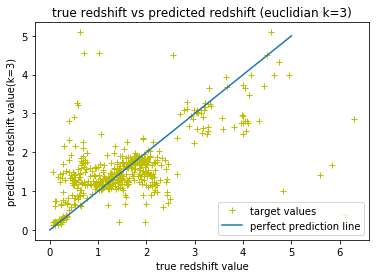

In [5]:
print("RMSE, k=3: " + str(RMSE(t_test, t_predictk3)))

domain = np.arange(t_test.shape[0])

plt.xlabel('true redshift value')
plt.ylabel('predicted redshift value(k=3)')
plt.title("true redshift vs predicted redshift (euclidian k=3)")
plt.plot(t_test, t_predictk3, "y+", label="target values")
plt.plot(np.arange(6), np.arange(6), label="perfect prediction line")
plt.legend()
plt.show()


In [6]:
#LOOCV

def pop_row(i, X, t):
    return X[i].reshape((1, -1)), t[i], np.delete(X, i, 0), np.delete(t, i, 0)

def LOOCV(X, t, model):
    N, P = X.shape
    loss = 0
    for n in range(N):
        Xn, tn, Xmn, tmn = pop_row(n, X, t)
        model.fit(Xmn, tmn)
        t_predict = model.predict(Xn)[0]
        loss += (tn - t_predict)**2
    return loss / N


errs = []
for k in range(1, 21):
    model = NearestNeighborRegressor(k)
    err = LOOCV(X_train, t_train, model)
    print("{}: {}".format(k, err))
    errs.append(err)
print("min: ", min(errs))



    

1: 1.5547538401647885
2: 1.1290347392793907
3: 0.9426526305469674
4: 0.8968212888163686
5: 0.8155617298918447
6: 0.8158512934229017
7: 0.8296250561252643
8: 0.8208078989736451
9: 0.79398657749987
10: 0.7857598052551606
11: 0.7856701455991337
12: 0.7926830652846353
13: 0.7996102888042957
14: 0.8049889308066452
15: 0.80167417637662
16: 0.8054988365742868
17: 0.8098871590141162
18: 0.8021665149986157
19: 0.8035837202739236
20: 0.80649688557224
min:  0.785670145599


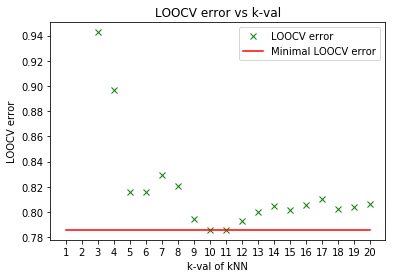

In [7]:
plt.plot(np.arange(3,21), errs[2:20], "gx", label="LOOCV error")
plt.plot([1,20], [min(errs), min(errs)], "r", label="Minimal LOOCV error")
plt.xticks(np.arange(1, 21))
plt.xlabel('k-val of kNN')
plt.ylabel('LOOCV error')
plt.title("LOOCV error vs k-val")
plt.legend()
plt.show()

In [8]:
modelk10 = NearestNeighborRegressor(10)
modelk10.fit(X_train, t_train)
t_predictk10 = modelk10.predict(X_test)

RMSE, k=10: 0.786977659095


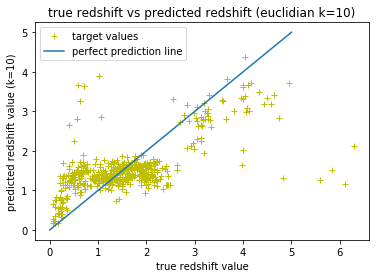

In [9]:
print("RMSE, k=10: " + str(RMSE(t_test, t_predictk10)))

plt.xlabel('true redshift value')
plt.ylabel('predicted redshift value (k=10)')
plt.title("true redshift vs predicted redshift (euclidian k=10)")
plt.plot(t_test, t_predictk10, "y+", label="target values")
plt.plot(np.arange(6), np.arange(6), label="perfect prediction line")
plt.legend()
plt.show()

In [10]:
diag_matrix = np.diag([0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 1, 1])
modelm =  NearestNeighborRegressor(3, "matrix", diag_matrix)
modelm.fit(X_train, t_train)
t_predictm = modelm.predict(X_test)



RMSE, matrix k=3: 27.8742184925


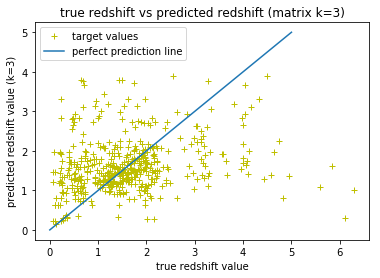

In [11]:
print("RMSE, matrix k=3: " + str(RMSE(t_test, t_predictm)))

plt.xlabel('true redshift value')
plt.ylabel('predicted redshift value (k=3)')
plt.title("true redshift vs predicted redshift (matrix k=3)")
plt.plot(t_test, t_predictm, "y+", label="target values")
plt.plot(np.arange(6), np.arange(6), label="perfect prediction line")
plt.legend()
plt.show()